In [ ]:
# %pip install numpy matplotlib scipy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.fft import fft
from scipy.signal import decimate, envelope, fftconvolve, correlate
import pandas as pd

In [2]:
# normalization from -1 to 1
def simetric_min_max(signal):
    signal_copy = signal.copy()
    signal_copy = signal_copy.astype(float)
    min_val = np.min(signal_copy)
    max_val = np.max(signal_copy)
    normalized_signal = 2 * (signal_copy - min_val) / (max_val - min_val) - 1
    return normalized_signal

min_max = lambda x: (x - x.min()) / (x.max() - x.min())

# function to compute Shannon Energy Envelope
def see(signal, window_size):
    """
    Versión optimizada que preserva *exactamente* el comportamiento
    numérico del implementation original (incluyendo casos límite).
    """
    # replicate original's behavior: operate in float (default float64)
    x = np.array(signal, copy=True, dtype=float)
    # squared signal
    s2 = x * x
    # same small constant inside log as original
    shannon_energy = -s2 * np.log(s2 + 1e-10)

    n = s2.size
    edges = int(window_size // 2)
    start = edges
    end = n - edges

    envelope = np.zeros(n, dtype=shannon_energy.dtype)

    # preserve edge assignments exactly like original
    if start > 0:
        envelope[:start] = shannon_energy[:start]
    if end < n:
        envelope[end:] = shannon_energy[end:]

    # Only perform the middle-window smoothing when the original loop would run.
    # The original loop runs for i in range(start, end).
    if start < end:
        # Special case: window_size == 1
        # The original code with window_size==1 computes slices i:i (empty)
        # and divides by 1, resulting in zeros for the middle region.
        # We replicate that behavior (i.e., do nothing — it's already zeros).
        if window_size == 1:
            pass
        else:
            k = 2 * edges  # length of slice used in original: i-edges : i+edges  -> length = 2*edges
            # If k == 0 we would be in a degenerate case; let Python raise if division by zero occurs later
            if k > 0 and (end - start) > 0:
                # convolution with ones gives sums over windows of length k.
                # mapping: envelope[i] (for i in [start, end-1]) should get
                # sum(shannon_energy[i-edges : i+edges]) / window_size
                # which corresponds to np.convolve(..., ones(k), mode='valid')[0 : end-start]
                valid = np.convolve(shannon_energy, np.ones(k, dtype=shannon_energy.dtype), mode='valid')
                # assign only the needed portion (exclude the last valid value to match original indexing)
                envelope[start:end] = valid[: (end - start) ] / float(window_size)

    return envelope.astype(np.float32)


def next_pow2(n: int) -> int:
    """Small helper: next power of two >= n (for n >= 1)."""
    if n <= 1:
        return 1
    return 1 << ((n - 1).bit_length())

def cross_correlation(x, y):
    max_len = max(len(x), len(y))
    seg_size = min(len(x), len(y))
    cxx = np.zeros(max_len) 
    for lag in range(max_len):
        seg_x = x[:max_len - lag]
        seg_y = y[lag:max_len] 
        cxx[lag] = np.sum(seg_x * seg_y) / (max_len - lag)
    return cxx

def cross_correlation_fft(x, y, exact=False):
    """
    Fast cross-correlation for non-negative lags using FFT convolution.

    Comportamiento:
      cxx[lag] = sum_{i=0..N-1-lag} x[i]*y[i+lag] / (N - lag)
    con N = min(len(x), len(y)), lag = 0..N-1.

    Parámetros:
    - x, y : array-like
    - exact : bool (default False). Si True, calcula la correlación con el método
      directo (suma por ventana) para garantizar igualdad bit-a-bit con la
      implementación original (más lento).

    Retorna:
    - np.ndarray dtype=float64 con longitud N
    """
    # Forzar arrays y dtype float64 (coincide con comportamiento original)
    xa = np.asarray(x, dtype=np.float64)
    ya = np.asarray(y, dtype=np.float64)

    N = min(xa.size, ya.size)
    if N == 0:
        return np.zeros(0, dtype=np.float64)

    # Si se pide exactitud bit-a-bit, usamos el método directo (lento pero idéntico).
    if exact:
        out = np.zeros(N, dtype=np.float64)
        for lag in range(N):
            seg_x = xa[: N - lag]
            seg_y = ya[lag: N]
            out[lag] = np.sum(seg_x * seg_y) / float(N - lag)
        return out

    # Truncar a N muestras (como en la versión original)
    xa = xa[:N]
    ya = ya[:N]

    # conv = xa * reverse(ya)  (la convolución con la reversa produce los sums requeridos)
    conv = fftconvolve(xa, ya[::-1], mode='full')

    # Conv viene en longitud 2*N-1; por ruido numérico puede tener una pequeña parte imaginaria:
    conv = np.real(conv)

    # Para lag = 0..N-1, el sum correspondiente está en conv[index = N-1 - lag].
    # Extraemos conv[N-1], conv[N-2], ..., conv[0] y tomamos los primeros N valores.
    sums = conv[N - 1 :: -1][:N].astype(np.float64)

    denom = np.arange(N, 0, -1, dtype=np.float64)  # [N, N-1, ..., 1]
    return (sums / denom).astype(np.float64)

# Función general: desliza el menor sobre el mayor y normaliza por len(menor)
def xcorr_valid_mean(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    if x.size < y.size:
        x, y = y, x
    return np.convolve(x, y[::-1], mode='valid') / y.size

In [3]:
audio_path = 'audios/pcg-bruno2.wav'
ecg = []
with open('/home/david/Documents/ECG_delineation/Delineation_ECG/wetransfer_ecgs_2024-09-09_1340/377-Bruno/Estudio.vak', 'r') as f:
    lines = f.readlines()
    for line in lines:
        ecg.append([x for x in line.split()])

ecg_x = np.asarray([np.float32(x[0].split(',')[0]) for x in ecg[1:]], dtype=np.float32)
# ecg_2 = np.asarray([np.float32(x[0].split(',')[2]) for x in ecg[1:]], dtype=np.float32)
ecg_2 = np.asarray([np.float32(x[2]) for x in ecg[1:]], dtype=np.float32)
ecg_2 /= np.max(np.abs(ecg_2))
ecg_2 = ecg_2[1698:]
sampling_freq, audio = wavfile.read(audio_path)
audio = audio[:,0].astype(np.float32)
# audio = decimate(audio, 20)
audio /= np.max(np.abs(audio))  # normalize to -1 to 1
# audio = min_max(audio)
audio_see = envelope(audio, residual=None)
audio = decimate(audio, 10)
audio_see = decimate(audio_see, 10)
audio = decimate(audio, 2)
audio_see = decimate(audio_see, 2)
# ecg_2_r = 1 where np.argmax(ecg_2[:300]) else 0
ecg_2_r = np.zeros_like(ecg_2[:300])
ecg_2_r[np.argmax(ecg_2[:300])+15] = 1

/tmp/ipykernel_765075/2952615752.py:13: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampling_freq, audio = wavfile.read(audio_path)


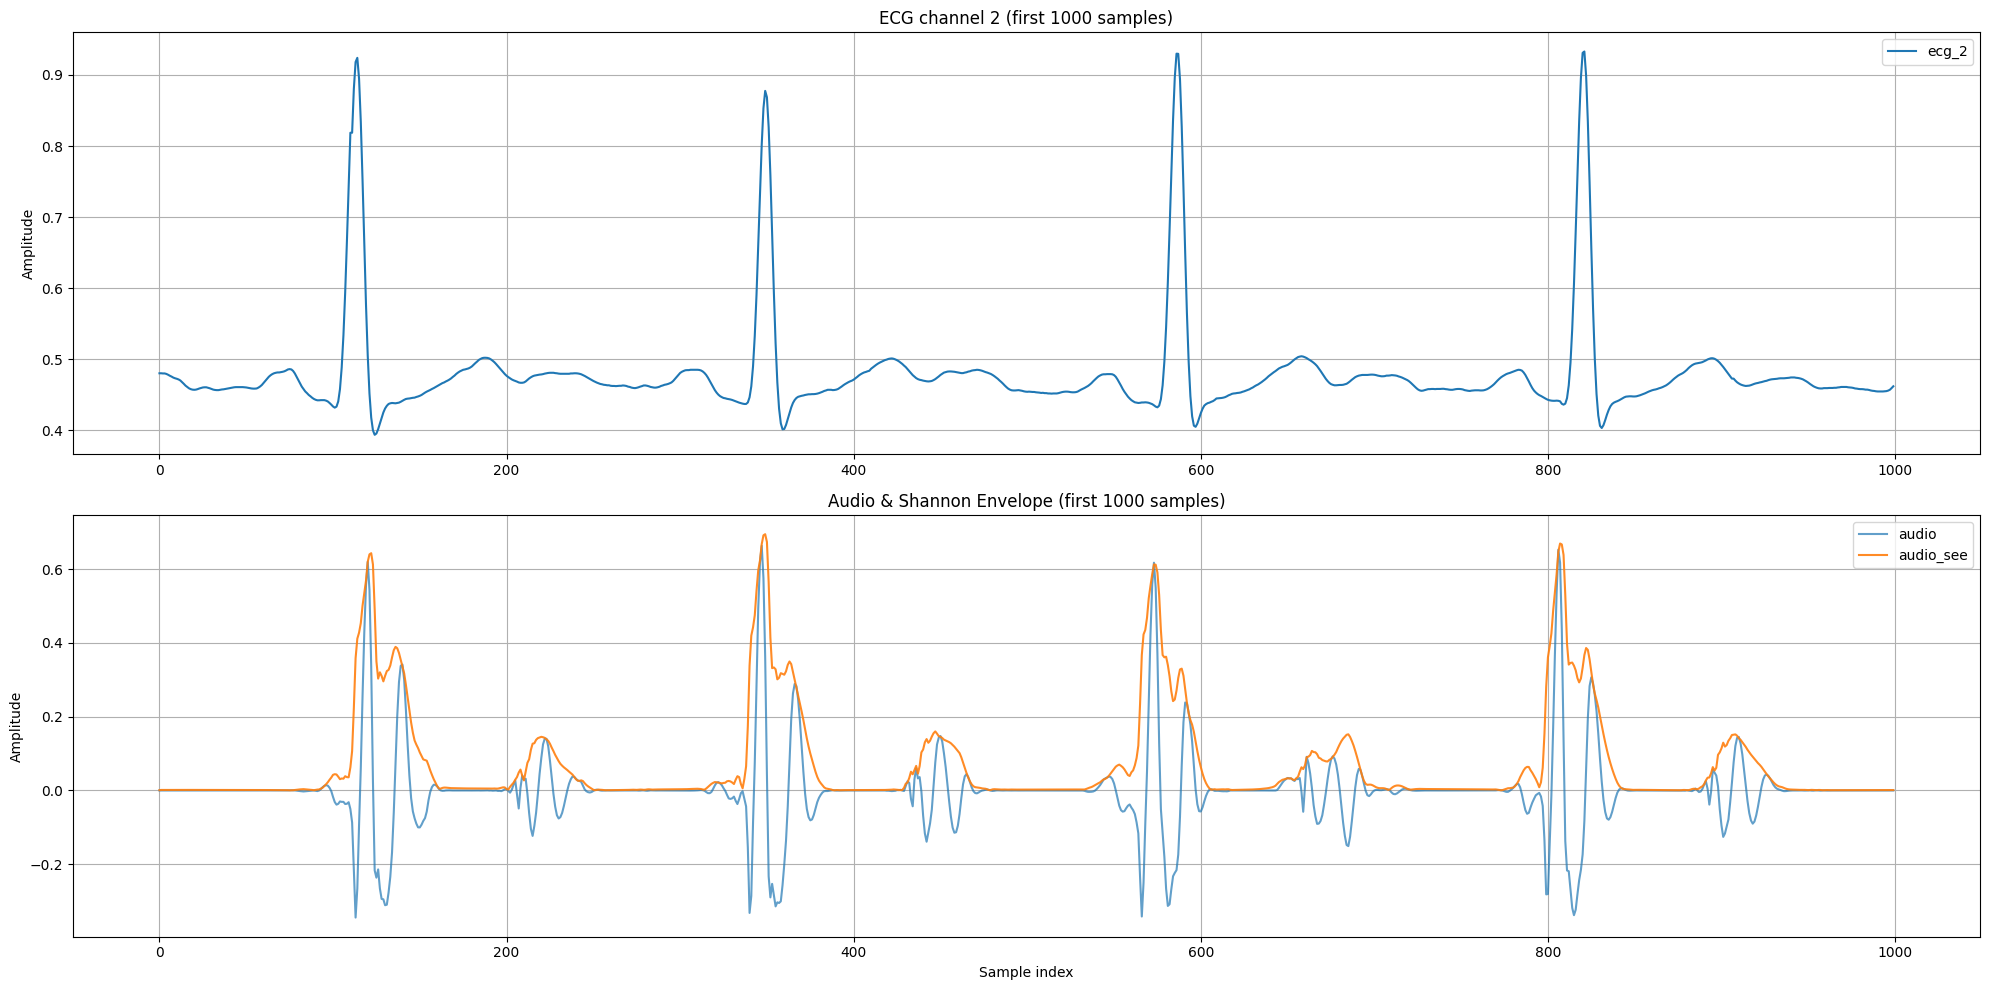

In [101]:
n = 1000
plt.figure(figsize=(20,10))

ax1 = plt.subplot(2,1,1)
ax1.plot(ecg_2[:n], label='ecg_2')
ax1.set_title(f'ECG channel 2 (first {n} samples)')
ax1.set_ylabel('Amplitude')
ax1.grid(True)
ax1.legend()

ax2 = plt.subplot(2,1,2, sharex=ax1)
ax2.plot(audio[:n], label='audio', alpha=0.7)
ax2.plot(audio_see[:n], label='audio_see', alpha=0.9)
ax2.set_title(f'Audio & Shannon Envelope (first {n} samples)')
ax2.set_xlabel('Sample index')
ax2.set_ylabel('Amplitude')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


In [99]:
cxx = correlate(ecg_2[:300], audio_see[:300], mode='full')
np.argmax(cxx)

np.int64(241)

In [63]:
audio_see = audio_see[:len(ecg_2)]
audio = audio[:len(ecg_2)]

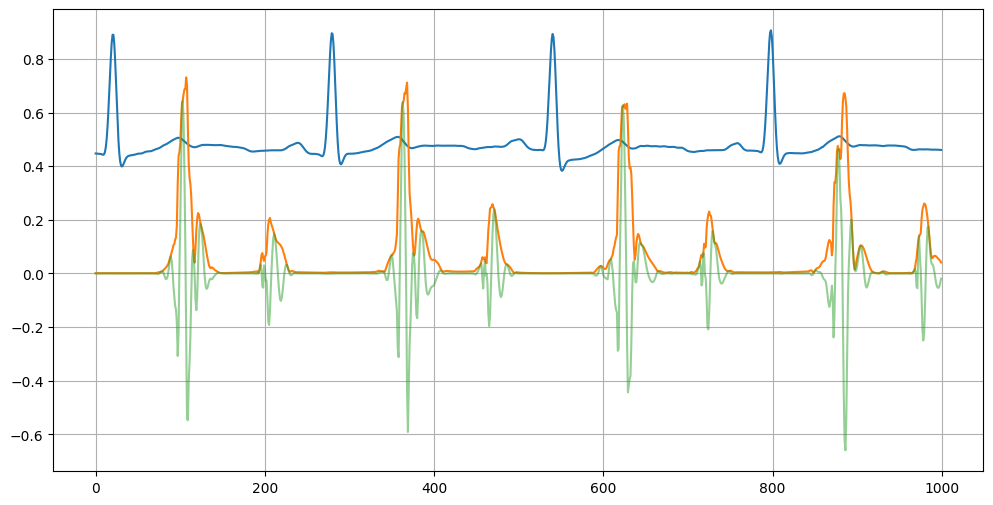

In [64]:
plt.figure(figsize=(12,6))
plt.plot(ecg_2[-1000:], label='ecg_2')
plt.plot(audio_see[-1000:], label='audio_see')
plt.plot(audio[-1000:], label='audio', alpha=0.5)
plt.grid(True)
plt.show()

In [ ]:
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Add traces, one for each slider step
for step in np.arange(0, 5, 0.1):
    fig.add_trace(
        go.Scatter(
            visible=False,
            line=dict(color="#00CED1", width=6),
            name="𝜈 = " + str(step),
            x=np.arange(0, len(audio)+1, 1),
            y=audio_see))  # Example data

# Make 10th trace visible
fig.data[10].visible = True

# Create and add slider
steps = []
for i in range(len(fig.data)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Slider switched to step: " + str(i)}],  # layout attribute
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=10,
    currentvalue={"prefix": "Frequency: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders
)

fig.show()

In [4]:
s1_peaks = np.loadtxt('s1_peaks_bruno.txt', dtype=int)
s1_rr = np.diff(s1_peaks)
print(s1_rr)

[227 224 234 245 254 249 244 240 235 234 233 234 232 242 244 242 244 247
 248 256 229]
